In [23]:
import torch
import jieba
import pandas as pd

data_dir = 'https://mirror.coggle.club/dataset/coggle-competition/'
train_data = pd.read_csv(data_dir + 'intent-classify/train.csv', sep='\t', header=None)
test_data = pd.read_csv(data_dir + 'intent-classify/test.csv', sep='\t', header=None)

In [24]:
train_data.head()

,0,1
0,还有双鸭山到淮阴的汽车票吗13号的,Travel-Query
1,从这里怎么回家,Travel-Query
2,随便播放一首专辑阁楼里的佛里的歌,Music-Play
3,给看一下墓王之王嘛,FilmTele-Play
4,我想看挑战两把s686打突变团竞的游戏视频,Video-Play


In [25]:
train_data.shape

(12100, 2)

In [26]:
train_data[1], lbl = pd.factorize(train_data[1])

In [27]:
def coustom_data_iter(texts, labels):
    for x, y in zip(texts, labels):
        yield x, y

In [28]:
train_iter = coustom_data_iter(train_data[0].values[:], train_data[1].values[:])

In [29]:
next(train_iter)

('还有双鸭山到淮阴的汽车票吗13号的', 0)

In [30]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = jieba.lcut

def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [31]:
vocab(['我们', '存在', '今天', '你好'])

[262, 7012, 41, 771]

In [32]:
def text_pipeline(x): return vocab(tokenizer(x))

In [33]:
text_pipeline('我们今天在这里学习323232dsdsd')

[262, 41, 32, 663, 1045, 0]

In [34]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_text, _label) in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

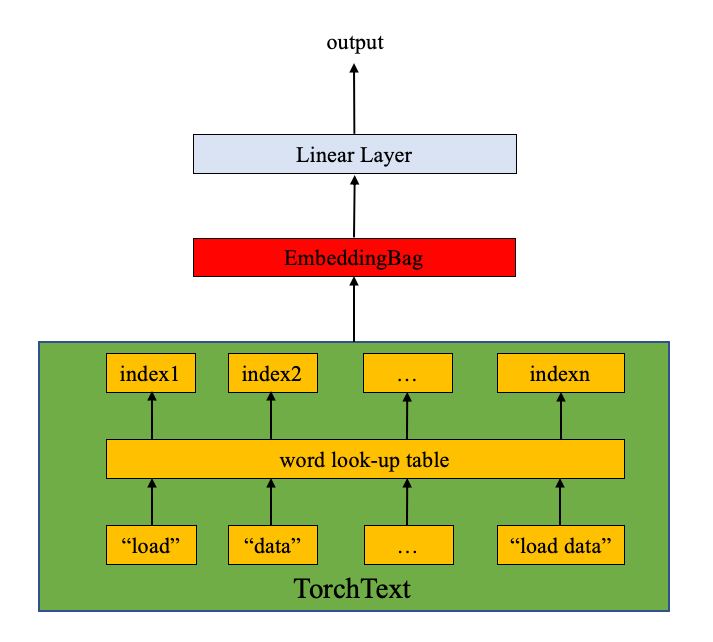

In [35]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [36]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [37]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

train_iter = coustom_data_iter(train_data[0].values[:], train_data[1].values[:])
train_dataset = to_map_style_dataset(train_iter)

num_train = int(len(train_dataset) * 0.75)
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

BATCH_SIZE = 16  # batch size for training
train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)

In [38]:
num_class = len(lbl)
vocab_size = len(vocab)
emsize = 32
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [39]:
# Hyperparameters
EPOCHS = 20  # epoch
LR = 5  # learning rate

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.5)
total_accu = None

In [40]:
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))

| end of epoch   1 | time:  2.11s | valid accuracy    0.829 
| end of epoch   2 | time:  1.78s | valid accuracy    0.868 
| end of epoch   3 | time:  1.82s | valid accuracy    0.882 
| end of epoch   4 | time:  1.72s | valid accuracy    0.896 
| end of epoch   5 | time:  1.80s | valid accuracy    0.889 
| end of epoch   6 | time:  1.76s | valid accuracy    0.899 
| end of epoch   7 | time:  1.75s | valid accuracy    0.901 
| end of epoch   8 | time:  1.79s | valid accuracy    0.901 
| end of epoch   9 | time:  1.63s | valid accuracy    0.903 
| end of epoch  10 | time:  1.59s | valid accuracy    0.902 
| end of epoch  11 | time:  1.77s | valid accuracy    0.903 
| end of epoch  12 | time:  2.19s | valid accuracy    0.902 
| end of epoch  13 | time:  2.00s | valid accuracy    0.902 
| end of epoch  14 | time:  2.17s | valid accuracy    0.902 
| end of epoch  15 | time:  2.32s | valid accuracy    0.902 
| end of epoch  16 | time:  2.15s | valid accuracy    0.902 
| end of epoch  17 | tim

In [41]:
test_iter = coustom_data_iter(test_data[0].values[:], [0] * len(test_data))
test_dataset = to_map_style_dataset(test_iter)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, collate_fn=collate_batch)

In [42]:
def predict(dataloader):
    model.eval()
    
    test_pred = []
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets).argmax(1)
            test_pred += list(predicted_label.cpu().numpy())
    return test_pred

In [43]:
test_pred = predict(test_dataloader)
test_pred = [lbl[x] for x in test_pred]

In [44]:
pd.DataFrame({
    'Id': range(1, len(test_pred) + 1),
    'Category': test_pred,
}).to_csv('nlp_submit.csv', index=None)
